<h1>CNN-P6 5-7-2016</h1>

<strong>Abstract</strong>
Implementing the CNN-P3 using NN1 described in the paper: http://arxiv.org/pdf/1509.00244v1.pdf. 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
%matplotlib inline

import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from scipy.ndimage.filters import gaussian_filter

from skimage import io
from skimage.color import rgb2grey
from skimage.transform import resize

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

np.random.seed(123456)

Using Theano backend.
Using gpu device 1: GRID K520 (CNMeM is enabled with initial size: 98.0% of memory, CuDNN 3007)


In [3]:
data_path = '../data/lfw_cropped'

img_rows, img_cols = 100, 100
noise_width = 15
num_people = 600

<h2>Loading Files</h2>

In [4]:
def get_face_to_file_path_dict():
    face_to_file_paths_dict = {}
    
    for root, dirnames, filenames in os.walk(data_path):
        for dirname in dirnames:
            if dirname not in face_to_file_paths_dict:
                face_to_file_paths_dict[dirname] = []
            directory_path = os.path.join(data_path, dirname)
            for filename in os.listdir(directory_path):
                if filename.endswith('_image.npy'):
                    face_to_file_paths_dict[dirname].append(os.path.join(directory_path, filename))
                            
    return face_to_file_paths_dict

In [5]:
def get_face_to_file_paths_descending_list(face_to_file_paths_dict):
    return sorted(face_to_file_paths_dict.items(), key=lambda x: len(x[1]), reverse=True)

In [6]:
face_to_file_paths_dict = get_face_to_file_path_dict()

In [7]:
face_to_file_paths_list = get_face_to_file_paths_descending_list(face_to_file_paths_dict)[:num_people]

<h2>Data Pre-Processing</h2>

In [8]:
def image_read(f):
    return np.load(f)

def reflection(image):
    return np.array([list(reversed(row)) for row in image])

def partition(image, top_left, rows, cols):
    return np.array([row[top_left[1]:top_left[1] + cols] for row in image[top_left[0]:top_left[0] + rows]])

In [9]:
def get_random_noise_image(image, coords, width):
    """
    Apply random gaussian generated values
    and distribute them on gaussian distributed square
    centered on the coordinates passed in for the image
    """
    
    noise = np.zeros((image.shape[0], image.shape[1]))
    for coord in coords:
        # Convert coordinates to rows / columns
        apply_noise_at_point(coord[1], coord[0], noise, width)
    return np.clip(image + noise, 0, 1)

def apply_noise_at_point(x, y, noise, width):
    """
    Generate a block with a single random value placed at the center
    Apply the Gaussian filter with std of 4
    Place it on the noise array at the appropriate coordinates
    
    x represents the rows
    y represents the cols
    """
    
    block = np.zeros((width, width))
    block[width / 2, width / 2] = np.random.normal()
    block = gaussian_filter(block, sigma=4)
    
    x -= width / 2
    y -= width / 2
    
    x_end = min(noise.shape[0] - x, block.shape[0])
    x_start =  max(0, -x)

    y_end = min(noise.shape[1] - y, block.shape[1])
    y_start = max(0, -y)

    noise[max(0, x):x+block.shape[0], max(0, y):y+block.shape[1]] = block[x_start:x_end,y_start:y_end]

In [10]:
def apply_noise(image, coords):
    return get_random_noise_image(image, coords, noise_width)

In [11]:
def get_feature_points(f):
    f = f.replace('image', 'features')
    return np.load(f)

def get_landmark_points(f):   
    f = f.replace('image', 'landmarks')
    return np.load(f)

In [12]:
def get_image_window(image, size, point):
    """
    Assume image is grey image
    """
    top = int(point[1] - size[0] / 2)
    left = int(point[0] - size[1] / 2)
    return image[top:top + size[0], left:left + size[1]]

In [13]:
images_by_class = [[(image_read(f), get_landmark_points(f), get_feature_points(f)) 
                    for f in x[1]] for x in face_to_file_paths_list]

In [14]:
# Create reflection with reflected coordinates
for i in range(len(images_by_class)):
    for j in range(len(images_by_class[i])):
        im, landmarks, features = images_by_class[i][j]
        new_features = [(im.shape[1] - p[0], p[1]) for p in features]
        new_landmarks = [(im.shape[1] - p[0], p[1]) for p in landmarks]
        new_landmarks[:3], new_landmarks[6:] = new_landmarks[6:], new_landmarks[:3]
        images_by_class[i].append((reflection(im), new_landmarks, new_features))

In [15]:
# Doubling the images and applying random gaussian noise
for i in range(len(images_by_class)):
    images_by_class[i] += images_by_class[i][:]
    images_by_class[i] = [(apply_noise(im, features), landmarks) 
                          for im, landmarks, features in images_by_class[i]]

In [16]:
# Get image of size 100x100, similar to the paper
for i in range(len(images_by_class)):
    images_by_class[i] = [get_image_window(im, (img_rows, img_cols), landmarks[5])
                          for im, landmarks in images_by_class[i]]

In [17]:
X_train = [image 
            for images in images_by_class 
            for image in images 
            if image.shape == (img_rows, img_cols)
            ]
y_train = [images[0] 
            for images in enumerate(images_by_class) 
            for image in images[1] 
            if image.shape == (img_rows, img_cols)
            ]

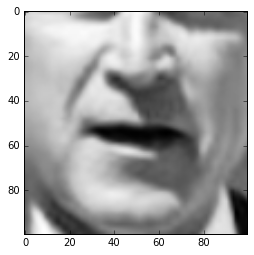

In [18]:
# Sanity Check
imshow(X_train[0], cmap='Greys_r')

In [19]:
zipped = np.array(zip(X_train, y_train))
np.random.shuffle(zipped)

In [20]:
X_train = np.array([x[0] for x in zipped])
y_train = np.array([x[1] for x in zipped])

In [21]:
X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
Y_train = np_utils.to_categorical(y_train, len(images_by_class))

<h2> Training and Validation</h2>

In [22]:
def NN1(input_shape, nb_classes, nb_fc6):
    model = Sequential()
    
    # Layer 1
    model.add(Convolution2D(64, 3, 3, activation='relu', input_shape=input_shape))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # Layer 2
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    # Layer 3
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #Layer 4
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    #Layer 5
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3))
    model.add(ZeroPadding2D((1,1)))
    model.add(AveragePooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(nb_fc6))
    model.add(Dense(nb_classes, activation='softmax'))
   
    return model

In [23]:
input_shape = (1, img_rows, img_cols)
nb_fc6 = 512

In [24]:
model = NN1(input_shape, num_people, nb_fc6)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, nb_epoch=10, 
        show_accuracy=True, verbose=1, shuffle=True, validation_split=.15)

Train on 22684 samples, validate on 4004 samples
Epoch 1/10
22684/22684 [==============================] - 309s - loss: 5.9007 - acc: 0.0730 - val_loss: 5.7054 - val_acc: 0.0862
Epoch 2/10
22684/22684 [==============================] - 309s - loss: 5.7562 - acc: 0.0782 - val_loss: 5.6789 - val_acc: 0.0862
Epoch 3/10
22684/22684 [==============================] - 309s - loss: 5.6951 - acc: 0.0790 - val_loss: 5.5689 - val_acc: 0.1006
Epoch 4/10
22684/22684 [==============================] - 309s - loss: 5.4655 - acc: 0.1044 - val_loss: 5.1109 - val_acc: 0.1384
Epoch 5/10
22684/22684 [==============================] - 309s - loss: 4.7780 - acc: 0.1720 - val_loss: 4.1443 - val_acc: 0.2355
Epoch 6/10
22684/22684 [==============================] - 309s - loss: 3.7692 - acc: 0.2758 - val_loss: 3.2273 - val_acc: 0.3509
Epoch 7/10
22684/22684 [==============================] - 309s - loss: 2.7449 - acc: 0.4096 - val_loss: 2.2892 - val_acc: 0.4983
Epoch 8/10
22684/22684 [========================

In [25]:
json_string = model.to_json()
open('models/CNN-P6_epoch-10.json', 'w').write(json_string)
model.save_weights('models/CNN-P6_epoch-10.h5', overwrite=True)

In [26]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=32, nb_epoch=10,
        show_accuracy=True, verbose=1, shuffle=True, validation_split=.15)

Train on 22684 samples, validate on 4004 samples
Epoch 1/10
22684/22684 [==============================] - 309s - loss: 0.1587 - acc: 0.9548 - val_loss: 0.3263 - val_acc: 0.9316
Epoch 2/10
22684/22684 [==============================] - 309s - loss: 0.0899 - acc: 0.9735 - val_loss: 0.2841 - val_acc: 0.9481
Epoch 3/10
22684/22684 [==============================] - 309s - loss: 0.0694 - acc: 0.9789 - val_loss: 0.2716 - val_acc: 0.9493
Epoch 4/10
22684/22684 [==============================] - 309s - loss: 0.0555 - acc: 0.9834 - val_loss: 0.2650 - val_acc: 0.9515
Epoch 5/10
22684/22684 [==============================] - 310s - loss: 0.0461 - acc: 0.9869 - val_loss: 0.2605 - val_acc: 0.9528
Epoch 6/10
22684/22684 [==============================] - 310s - loss: 0.0428 - acc: 0.9874 - val_loss: 0.2592 - val_acc: 0.9525
Epoch 7/10
22684/22684 [==============================] - 309s - loss: 0.0383 - acc: 0.9888 - val_loss: 0.2449 - val_acc: 0.9570
Epoch 8/10
22684/22684 [========================

In [27]:
json_string = model.to_json()
open('models/CNN-P6_epoch-20.json', 'w').write(json_string)
model.save_weights('models/CNN-P6_epoch-20.h5', overwrite=True)